In [4]:
# Import few matplotlib functions
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

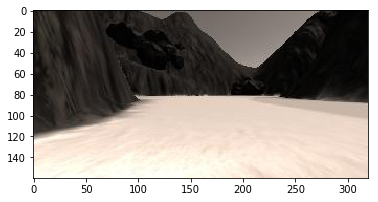

In [5]:
# Define the filename, read and plot the image
filename = 'sample.jpg'
image = mpimg.imread(filename)
plt.imshow(image)
plt.show()

In [6]:
# Import numpy to work with arrays
import numpy as np
print(image.dtype, image.shape, np.min(image), np.max(image))

uint8 (160, 320, 3) 0 255


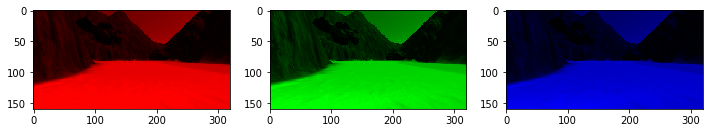

In [7]:
# RGB (keep order in mind to zeroing out colors)

red_channel = np.copy(image)
red_channel[:,:,[1,2]] = 0 # Zero out green and blue channels

green_channel = np.copy(image)
green_channel[:,:,[0,2]] = 0 # Zero out red and blue channels

blue_channel = np.copy(image)
blue_channel[:,:,[0,1]] = 0 # Zero out red and green channels

fig = plt.figure(figsize=(12,4)) # Create a figure for plotting
plt.subplot(131)
plt.imshow(red_channel)
plt.subplot(132)
plt.imshow(green_channel)
plt.subplot(133)
plt.imshow(blue_channel)
plt.show()

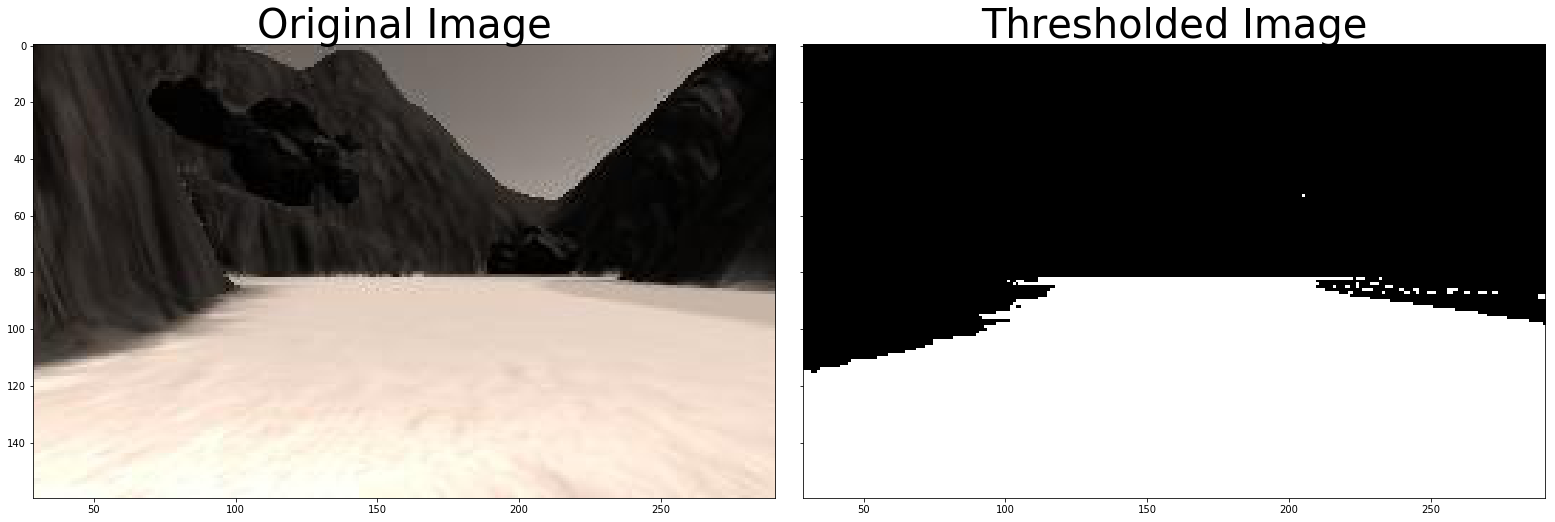

In [8]:
# Define a function to perform a color threshold

def color_thresh(img, rgb_thresh=(0, 0, 0)):
    binary_image = np.zeros_like(img[:,:,0])  # Creating a 2D zero array 
    above_threshold = (img[:,:,0] > rgb_thresh[0]) & (img[:,:,1] > rgb_thresh[1]) & (img[:,:,2] > rgb_thresh[2])
    binary_image[above_threshold] = 1
    return binary_image

# Modify these variables to decide threshold
red_threshold = 170
green_threshold = 170
blue_threshold = 170

rgb_threshold = (red_threshold, green_threshold, blue_threshold)

image_threshold = color_thresh(image, rgb_thresh=rgb_threshold)

# Display original image and binary
f, (ax1, ax2) = plt.subplots(1,2,figsize=(21,7),sharey=True)
f.tight_layout()

ax1.imshow(image)
ax1.set_title('Original Image', fontsize = 40)
ax2.imshow(image_threshold, cmap='gray')
ax2.set_title('Thresholded Image', fontsize = 40)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

<IPython.core.display.Javascript object>


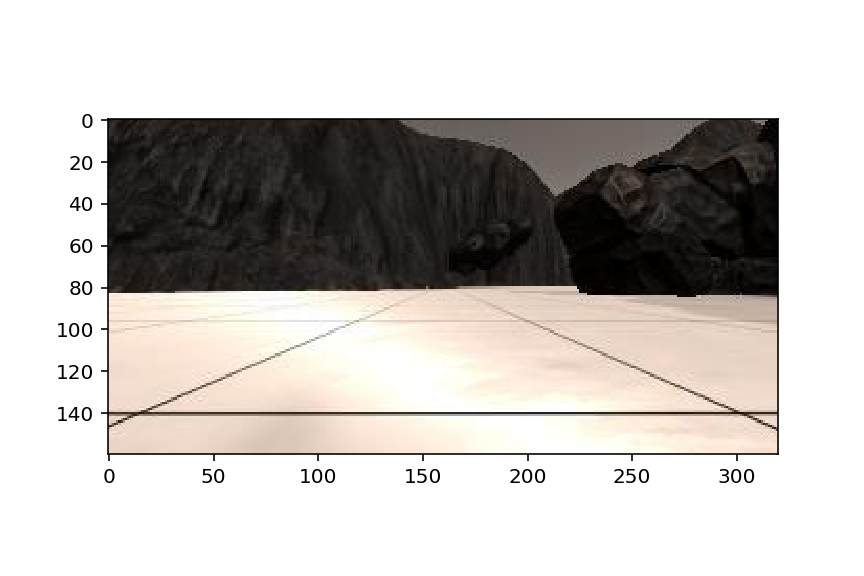

In [10]:
# Calling it twice because problem arises if you switch from inline to notebook without restarting the kernel
%matplotlib notebook
%matplotlib notebook 

grid_image = mpimg.imread('example_grid1.jpg')
plt.imshow(grid_image)
plt.show()

Recording points observed on the interactive image above (Source points)- <br/><br/>
Point 1 (Bottom-Left) &nbsp;&nbsp;: x = 14.3  y = 140.9 [101,85,72] <br/>
Point 2 (Bottom-Right): x = 301.9 y = 140.9 [141,123,111] <br/>
Point 3 (Top-Right) &nbsp;&nbsp;&nbsp;: x = 199.7 y = 95.9  [169,147,133] <br/>
Point 4 (Top-Left) &nbsp;&nbsp;&nbsp;&nbsp;: x = 117.5 y = 95.9  [179,180,162] <br/>


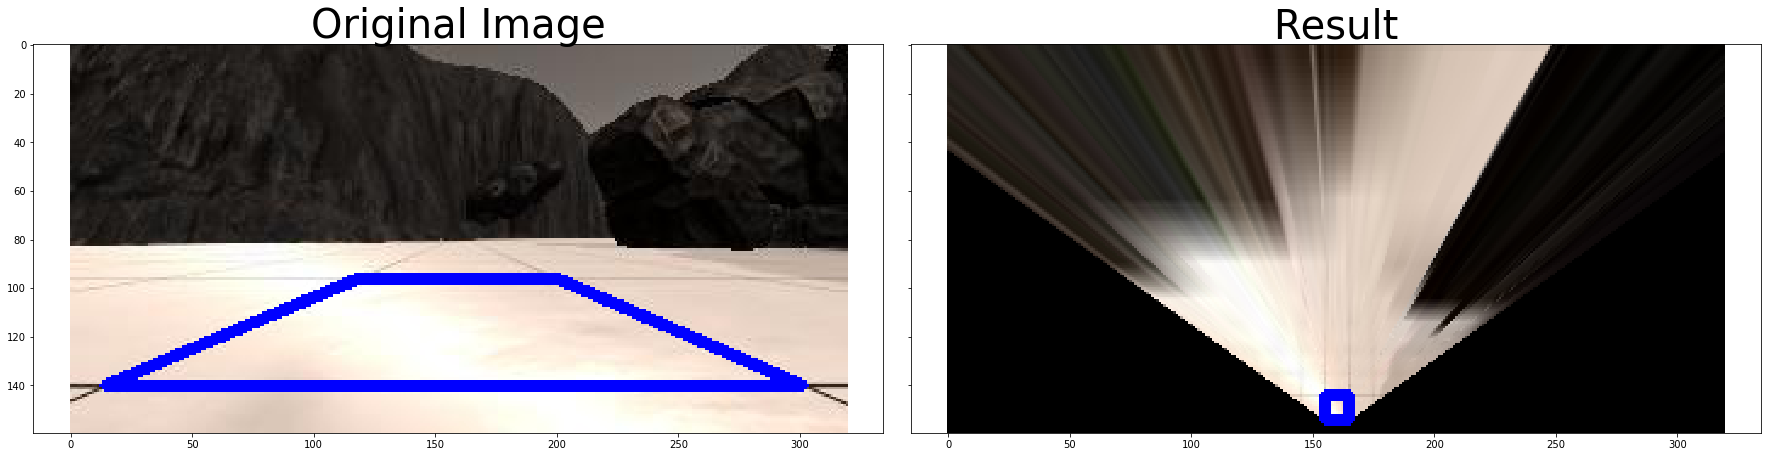

In [11]:
# Performing Perspective Transform

%matplotlib inline
import cv2


def perspect_transform(image, src_points, dst_points):
    M = cv2.getPerspectiveTransform(src_points, dst_points)
    warped_image = cv2.warpPerspective(image, M, (image.shape[1], image.shape[0])) # keep the size of the image the same (The last input is output image size)
    return warped_image


dst_size = 5 # half of distance between adjacent destination points
bottom_offset = 6 

# Define source and destination points
#source = np.float32([[14.3,140.9],[301.9,140.9],[199.7,95.9],[117.5,95.9]])        # float32 - Single precision float

source = np.float32([[14, 140], [301 ,140],[200, 96], [118, 96]])
destination = np.float32([[image.shape[1]/2 - dst_size, image.shape[0] - bottom_offset],
                          [image.shape[1]/2 + dst_size, image.shape[0] - bottom_offset],
                          [image.shape[1]/2 + dst_size, image.shape[0] - 2*dst_size - bottom_offset], 
                          [image.shape[1]/2 - dst_size, image.shape[0] - 2*dst_size - bottom_offset],
                        ])

warped_image = perspect_transform(grid_image, source, destination)

grid_image = mpimg.imread('example_grid1.jpg') # load it again just in case it already has polylines executed on the image

# Draw source and destination points on images (in blue) before plotting
cv2.polylines(grid_image, np.int32([source]), True, (0,0,255), 3)
cv2.polylines(warped_image, np.int32([destination]), True, (0,0,255), 3)

# Display the original image and binary               
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 6), sharey=True)
f.tight_layout()

ax1.imshow(grid_image)
ax1.set_title('Original Image', fontsize=40)
ax2.imshow(warped_image, cmap='gray')
ax2.set_title('Result', fontsize=40)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

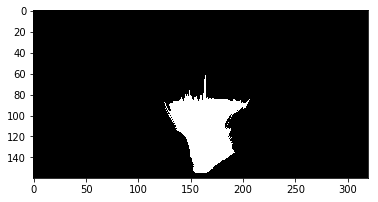

In [19]:
# Perform Perspective Transform and Color Threshholding to find navigable terrain

image = mpimg.imread('sample.jpg')
warped = perspect_transform(image, source, destination)
perspective_thresh = color_thresh(warped, (160,160,160))

plt.imshow(perspective_thresh, cmap ='gray')
plt.show()

# This picture tells us the rover's world from above
# The position of the rover camera in this image would be roughly at (160,160)

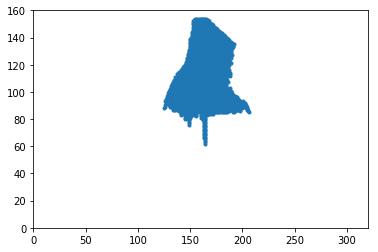

In [21]:
# Converting to Rover-Centric Coordinates - to find position of things w.r.t robot

# pixel positions in image space (Changing origin position - y-axis reversed)
ypos, xpos = perspective_thresh.nonzero()
plt.plot(xpos, ypos, '.')
plt.xlim(0, 320)
plt.ylim(0, 160)
plt.show()

Text(0.5,1,'Rover-Centric Map')

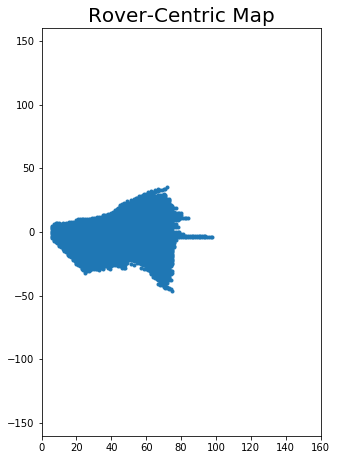

In [25]:
# Function to take in a binary image, extract the x and y positions in image coordinates and return x and y in rover coordinates
def rover_coords(binary_img):
    # Identify non-zero numbers
    xpos, ypos = binary_img.nonzero() 
    # Rover camera at (0,0)
    x_pixel = (binary_img.shape[0] - xpos).astype(np.float)
    y_pixel = (binary_img.shape[1]/2 - ypos).astype(np.float)
    return x_pixel, y_pixel

# Extract x and y positions of navigable terrain pixels
# and convert to rover coordinates
xpix, ypix = rover_coords(perspective_thresh)

# Plot the map in rover-centric coords
fig = plt.figure(figsize=(5, 7.5))
plt.plot(xpix, ypix, '.')
plt.ylim(-160, 160)
plt.xlim(0, 160)
plt.title('Rover-Centric Map', fontsize=20)